<a href="https://colab.research.google.com/github/EdwardCaleb/Reinforcement-Learning-CSE437/blob/main/lab4_dyna_EdwardLopez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


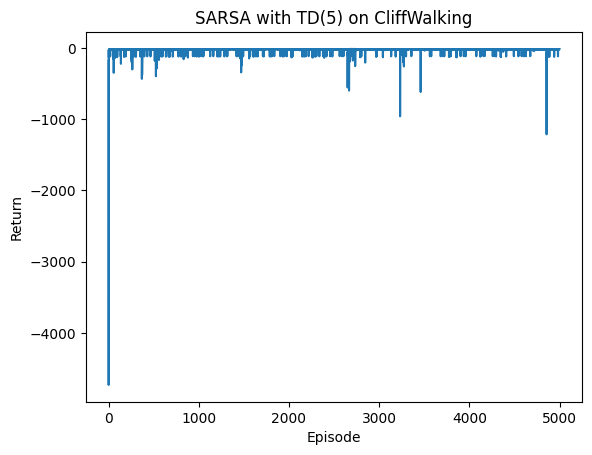

In [36]:
"""
SARSA with TD(5) on CliffWalking-v1
"""

import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

# Environment
env = gym.make("CliffWalking-v1")

# Parameters
n_states = env.observation_space.n
n_actions = env.action_space.n
alpha = 0.1           # step size (learning rate)
gamma = 0.99          # discount factor
epsilon = 0.1         # epsilon for epsilon-greedy policy
n_step = 5            # number of steps for TD(n)
n_episodes = 5000

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

def epsilon_greedy(state):
    """Choose an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

# Track returns
episode_returns_nstep = []

for ep in range(n_episodes):
    state, _ = env.reset()
    action = epsilon_greedy(state)

    # Buffers to store the trajectory (index like lists)
    states = deque([state])     # store S_0 immediately
    actions = deque([action])   # store A_0 immediately
    rewards = deque()           # will store R_{t+1} each step

    T = float("inf")  # time of termination (first index AFTER last reward)
    t = 0

    while True:
        if t < T:
            # Take a real step using the current action
            next_state, reward, terminated, truncated, _ = env.step(actions[t])
            done = terminated or truncated

            # Store the observed reward R_{t+1}
            rewards.append(reward)

            if done:
                T = t + 1  # first time index after the last reward
            else:
                # Choose and store the next (S, A) immediately
                next_action = epsilon_greedy(next_state)
                states.append(next_state)
                actions.append(next_action)

        # Time whose estimate is being updated
        tau = t - n_step + 1

        if tau >= 0:
            # --------- n-step return G for state tau ----------
            G = 0.0
            # Sum rewards R_{tau+1} .. R_{min(tau+n, T)}
            upper = min(tau + n_step, T if T != float("inf") else t + 1)
            for i in range(tau, int(upper)):
                # rewards[i] corresponds to R_{i+1}
                G += (gamma ** (i - tau)) * rewards[i]

            # Bootstrap from Q(S_{tau+n}, A_{tau+n}) if not terminal within n steps
            if tau + n_step < T:
                # At this point (because we appended S and A immediately) the entries exist
                s_tau_n = states[tau + n_step]
                a_tau_n = actions[tau + n_step]
                G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

            # ------------ Update Q(S_tau, A_tau) ---------------
            s_tau = states[tau]
            a_tau = actions[tau]
            Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

        if tau == T - 1:
            break

        t += 1

    episode_returns_nstep.append(sum(rewards))

# Plot learning curve
plt.plot(episode_returns_nstep)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("SARSA with TD(5) on CliffWalking")
# plt.ylim(top=10)  # adjust the top leaving bottom unchanged
# plt.ylim(bottom=-1000)  # adjust the bottom leaving top unchanged
plt.show()

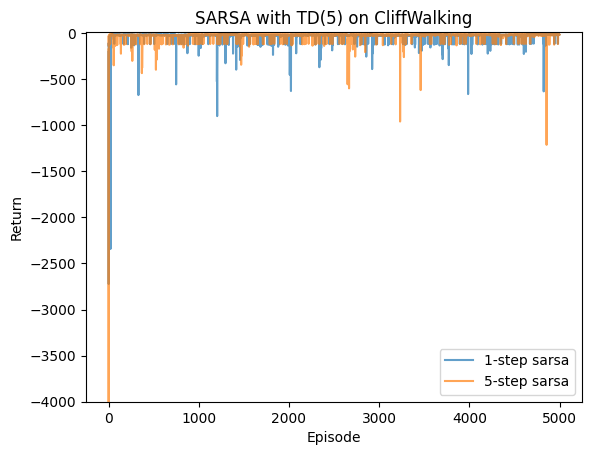

In [46]:
"""
SARSA with TD(1) on CliffWalking-v1
"""

import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

# Environment
env = gym.make("CliffWalking-v1")

# Parameters
n_states = env.observation_space.n
n_actions = env.action_space.n
alpha = 0.1           # step size (learning rate)
gamma = 0.99          # discount factor
epsilon = 0.1         # epsilon for epsilon-greedy policy
n_step = 5            # number of steps for TD(n)
n_episodes = 5000

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

def epsilon_greedy(state):
    """Choose an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

# Track returns
episode_returns = []

for ep in range(n_episodes):
    state, _ = env.reset()
    action = epsilon_greedy(state)

    # Buffers to store the trajectory (index like lists)
    states = deque([state])     # store S_0 immediately
    actions = deque([action])   # store A_0 immediately
    rewards = deque()           # will store R_{t+1} each step

    T = float("inf")  # time of termination (first index AFTER last reward)
    t = 0

    while True:
        if t < T:
            # Take a real step using the current action
            next_state, reward, terminated, truncated, _ = env.step(actions[t])
            done = terminated or truncated

            # Store the observed reward R_{t+1}
            rewards.append(reward)

            if done:
                T = t + 1  # first time index after the last reward
            else:
                # Choose and store the next (S, A) immediately
                next_action = epsilon_greedy(next_state)
                states.append(next_state)
                actions.append(next_action)

        # Time whose estimate is being updated
        tau = t - n_step + 1

        if tau >= 0:
            # --------- n-step return G for state tau ----------
            G = 0.0
            # Sum rewards R_{tau+1} .. R_{min(tau+n, T)}
            upper = min(tau + n_step, T if T != float("inf") else t + 1)
            for i in range(tau, int(upper)):
                # rewards[i] corresponds to R_{i+1}
                G += (gamma ** (i - tau)) * rewards[i]

            # Bootstrap from Q(S_{tau+n}, A_{tau+n}) if not terminal within n steps
            if tau + n_step < T:
                # At this point (because we appended S and A immediately) the entries exist
                s_tau_n = states[tau + n_step]
                a_tau_n = actions[tau + n_step]
                G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

            # ------------ Update Q(S_tau, A_tau) ---------------
            s_tau = states[tau]
            a_tau = actions[tau]
            Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

        if tau == T - 1:
            break

        t += 1

    episode_returns.append(sum(rewards))

# Plot learning curve
plt.plot(episode_returns, label="1-step sarsa", alpha=0.7)
plt.plot(episode_returns_nstep, label="5-step sarsa", alpha=0.7)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("SARSA with TD(5) on CliffWalking")
plt.ylim([-4000,10])
plt.legend()
plt.show()


Convergence of 5-step sarsa is generally faster than 1-step; and in the policy, 1-step sarsa is safer and more conservative; n-step sarsa is more optimal but risker. However, overall in the long term its not possible to notice any big difference between both algoritms in tasks like the Cliff walker, and probably it is necessary to make more iterations to see which of them is better in terms of convergence and policy.

## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




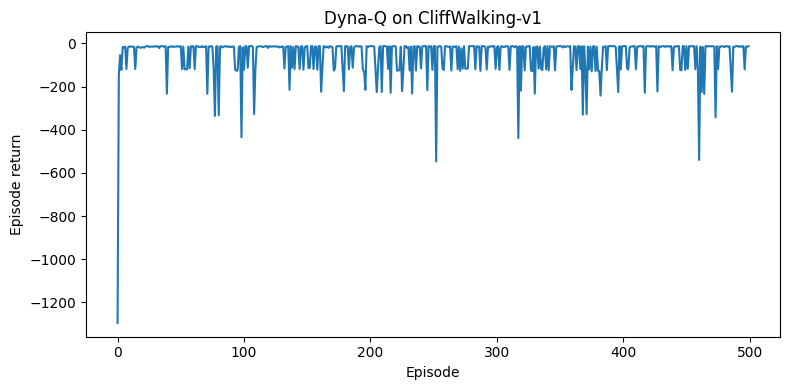

In [62]:
"""
Part A — Dyna-Q (Implementation)
Tabular Dyna-Q on CliffWalking-v1
"""

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


# ----------------------------
# Tabular Dyna-Q on CliffWalking-v1
# ----------------------------

env = gym.make("CliffWalking-v1")
nS = env.observation_space.n
nA = env.action_space.n
rng = np.random.default_rng(0)

# hyperparameters
episodes = 500
alpha = 0.1
gamma = 0.99
epsilon = 0.1
N_planning = 20   # n planning steps per real step

# Q and Model initialization
Q = np.zeros((nS, nA))
model = {}                 # (s,a) -> (r, s')
seen_sa = []               # list of seen (s,a) for uniform sampling

def epsilon_greedy(s):
    if rng.random() < epsilon:
        return int(rng.integers(nA))
    row = Q[s]
    return int(rng.choice(np.flatnonzero(row == row.max())))

returns = []

for ep in range(episodes):
    # (a) S <- current (nonterminal) state
    S, _ = env.reset(seed=ep)
    done = False
    G = 0.0

    while not done:
        # (b) A <- ε-greedy(S, Q)
        A = epsilon_greedy(S)

        # (c) Take action A; observe R, S'
        S_next, R, terminated, truncated, _ = env.step(A)
        done = terminated or truncated
        G += R

        # (d) Q(S,A) update (Q-learning target)
        target = R if done else R + gamma * Q[S_next].max()
        Q[S, A] += alpha * (target - Q[S, A])

        # (e) Model(S,A) <- (R, S')
        if (S, A) not in model:
            seen_sa.append((S, A))
        model[(S, A)] = (R, S_next)

        # (f) Loop repeat N times (planning)
        for _ in range(N_planning):
            # S~ <- random previously observed state
            # A~ <- random action previously taken in S~
            i = int(rng.integers(len(seen_sa)))
            S_tilde, A_tilde = seen_sa[i]

            # R~, S'~ <- Model(S~, A~)
            R_tilde, S_next_tilde = model[(S_tilde, A_tilde)]

            # Q(S~,A~) update using the model transition
            # (treat reaching the true terminal as non-bootstrapping)
            # CliffWalking marks terminal only at the goal state,
            # which we cannot check directly here, so just bootstrap always.
            target_tilde = R_tilde + gamma * Q[S_next_tilde].max()
            Q[S_tilde, A_tilde] += alpha * (target_tilde - Q[S_tilde, A_tilde])

        # move to next real state
        S = S_next

    returns.append(G)

env.close()

# -------- plot learning curve --------
plt.figure(figsize=(8,4))
plt.plot(returns, lw=1.5)
plt.xlabel("Episode")
plt.ylabel("Episode return")
plt.title("Dyna-Q on CliffWalking-v1")
plt.tight_layout()
plt.show()


In [69]:
"""
Part B — Baselines (Re-use / Implement)
SARSA with TD(5) - 5 times on CliffWalking-v1
"""

import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

me_matrix_td5 = []

for _ in range(5):

  # Environment
  env = gym.make("CliffWalking-v1")

  # Parameters
  n_states = env.observation_space.n
  n_actions = env.action_space.n
  alpha = 0.1           # step size (learning rate)
  gamma = 0.99          # discount factor
  epsilon = 0.1         # epsilon for epsilon-greedy policy
  n_step = 5            # number of steps for TD(n)
  n_episodes = 200

  # Initialize Q-table
  Q = np.zeros((n_states, n_actions))

  def epsilon_greedy(state):
      """Choose an action using epsilon-greedy policy."""
      if np.random.rand() < epsilon:
          return np.random.randint(n_actions)
      return np.argmax(Q[state])

  # Track returns
  episode_returns_nstep = []

  for _ in range(n_episodes):
      state, _ = env.reset()
      action = epsilon_greedy(state)

      # Buffers to store the trajectory (index like lists)
      states = deque([state])     # store S_0 immediately
      actions = deque([action])   # store A_0 immediately
      rewards = deque()           # will store R_{t+1} each step

      T = float("inf")  # time of termination (first index AFTER last reward)
      t = 0

      while True:
          if t < T:
              # Take a real step using the current action
              next_state, reward, terminated, truncated, _ = env.step(actions[t])
              done = terminated or truncated

              # Store the observed reward R_{t+1}
              rewards.append(reward)

              if done:
                  T = t + 1  # first time index after the last reward
              else:
                  # Choose and store the next (S, A) immediately
                  next_action = epsilon_greedy(next_state)
                  states.append(next_state)
                  actions.append(next_action)

          # Time whose estimate is being updated
          tau = t - n_step + 1

          if tau >= 0:
              # --------- n-step return G for state tau ----------
              G = 0.0
              # Sum rewards R_{tau+1} .. R_{min(tau+n, T)}
              upper = min(tau + n_step, T if T != float("inf") else t + 1)
              for i in range(tau, int(upper)):
                  # rewards[i] corresponds to R_{i+1}
                  G += (gamma ** (i - tau)) * rewards[i]

              # Bootstrap from Q(S_{tau+n}, A_{tau+n}) if not terminal within n steps
              if tau + n_step < T:
                  # At this point (because we appended S and A immediately) the entries exist
                  s_tau_n = states[tau + n_step]
                  a_tau_n = actions[tau + n_step]
                  G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

              # ------------ Update Q(S_tau, A_tau) ---------------
              s_tau = states[tau]
              a_tau = actions[tau]
              Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

          if tau == T - 1:
              break

          t += 1

      episode_returns_nstep.append(sum(rewards))

  me_matrix_td5.append(episode_returns_nstep)


In [70]:
"""
Part B — Baselines (Re-use / Implement)
SARSA with TD(1) - 5 times on CliffWalking-v1
"""

import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

me_matrix_td1 = []

for _ in range(5):

  # Environment
  env = gym.make("CliffWalking-v1")

  # Parameters
  n_states = env.observation_space.n
  n_actions = env.action_space.n
  alpha = 0.1           # step size (learning rate)
  gamma = 0.99          # discount factor
  epsilon = 0.1         # epsilon for epsilon-greedy policy
  n_step = 5            # number of steps for TD(n)
  n_episodes = 200

  # Initialize Q-table
  Q = np.zeros((n_states, n_actions))

  def epsilon_greedy(state):
      """Choose an action using epsilon-greedy policy."""
      if np.random.rand() < epsilon:
          return np.random.randint(n_actions)
      return np.argmax(Q[state])

  # Track returns
  episode_returns = []

  for ep in range(n_episodes):
      state, _ = env.reset()
      action = epsilon_greedy(state)

      # Buffers to store the trajectory (index like lists)
      states = deque([state])     # store S_0 immediately
      actions = deque([action])   # store A_0 immediately
      rewards = deque()           # will store R_{t+1} each step

      T = float("inf")  # time of termination (first index AFTER last reward)
      t = 0

      while True:
          if t < T:
              # Take a real step using the current action
              next_state, reward, terminated, truncated, _ = env.step(actions[t])
              done = terminated or truncated

              # Store the observed reward R_{t+1}
              rewards.append(reward)

              if done:
                  T = t + 1  # first time index after the last reward
              else:
                  # Choose and store the next (S, A) immediately
                  next_action = epsilon_greedy(next_state)
                  states.append(next_state)
                  actions.append(next_action)

          # Time whose estimate is being updated
          tau = t - n_step + 1

          if tau >= 0:
              # --------- n-step return G for state tau ----------
              G = 0.0
              # Sum rewards R_{tau+1} .. R_{min(tau+n, T)}
              upper = min(tau + n_step, T if T != float("inf") else t + 1)
              for i in range(tau, int(upper)):
                  # rewards[i] corresponds to R_{i+1}
                  G += (gamma ** (i - tau)) * rewards[i]

              # Bootstrap from Q(S_{tau+n}, A_{tau+n}) if not terminal within n steps
              if tau + n_step < T:
                  # At this point (because we appended S and A immediately) the entries exist
                  s_tau_n = states[tau + n_step]
                  a_tau_n = actions[tau + n_step]
                  G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

              # ------------ Update Q(S_tau, A_tau) ---------------
              s_tau = states[tau]
              a_tau = actions[tau]
              Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

          if tau == T - 1:
              break

          t += 1

      episode_returns.append(sum(rewards))

  me_matrix_td1.append(episode_returns)



In [71]:
"""
Part C — Experiments & Comparisons
Tabular Dyna-Q on CliffWalking-v1 - 5 times / N = 5, 20, 50
"""

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


me_matrix_dyna_05 = []
me_matrix_dyna_20 = []
me_matrix_dyna_50 = []

for metrics in range(15):
  if metrics >= 0 and metrics < 5:
    N_planning = 5
  elif metrics >= 5 and metrics < 10:
    N_planning = 20
  elif metrics >= 10 and metrics < 15:
    N_planning = 50

  # ----------------------------
  # Tabular Dyna-Q on CliffWalking-v1
  # ----------------------------

  env = gym.make("CliffWalking-v1")
  nS = env.observation_space.n
  nA = env.action_space.n
  rng = np.random.default_rng(0)

  # hyperparameters
  episodes = 200
  alpha = 0.1
  gamma = 0.99
  epsilon = 0.1
  # N_planning = 20   # n planning steps per real step

  # Q and Model initialization
  Q = np.zeros((nS, nA))
  model = {}                 # (s,a) -> (r, s')
  seen_sa = []               # list of seen (s,a) for uniform sampling

  def epsilon_greedy(s):
      if rng.random() < epsilon:
          return int(rng.integers(nA))
      row = Q[s]
      return int(rng.choice(np.flatnonzero(row == row.max())))

  returns = []

  for ep in range(episodes):
      # (a) S <- current (nonterminal) state
      S, _ = env.reset(seed=ep)
      done = False
      G = 0.0

      while not done:
          # (b) A <- ε-greedy(S, Q)
          A = epsilon_greedy(S)

          # (c) Take action A; observe R, S'
          S_next, R, terminated, truncated, _ = env.step(A)
          done = terminated or truncated
          G += R

          # (d) Q(S,A) update (Q-learning target)
          target = R if done else R + gamma * Q[S_next].max()
          Q[S, A] += alpha * (target - Q[S, A])

          # (e) Model(S,A) <- (R, S')
          if (S, A) not in model:
              seen_sa.append((S, A))
          model[(S, A)] = (R, S_next)

          # (f) Loop repeat N times (planning)
          for _ in range(N_planning):
              # S~ <- random previously observed state
              # A~ <- random action previously taken in S~
              i = int(rng.integers(len(seen_sa)))
              S_tilde, A_tilde = seen_sa[i]

              # R~, S'~ <- Model(S~, A~)
              R_tilde, S_next_tilde = model[(S_tilde, A_tilde)]

              # Q(S~,A~) update using the model transition
              # (treat reaching the true terminal as non-bootstrapping)
              # CliffWalking marks terminal only at the goal state,
              # which we cannot check directly here, so just bootstrap always.
              target_tilde = R_tilde + gamma * Q[S_next_tilde].max()
              Q[S_tilde, A_tilde] += alpha * (target_tilde - Q[S_tilde, A_tilde])

          # move to next real state
          S = S_next

      returns.append(G)

  env.close()

  if metrics >= 0 and metrics < 5:
    me_matrix_dyna_05.append(returns)
  elif metrics >= 5 and metrics < 10:
    me_matrix_dyna_20.append(returns)
  elif metrics >= 10 and metrics < 15:
    me_matrix_dyna_50.append(returns)



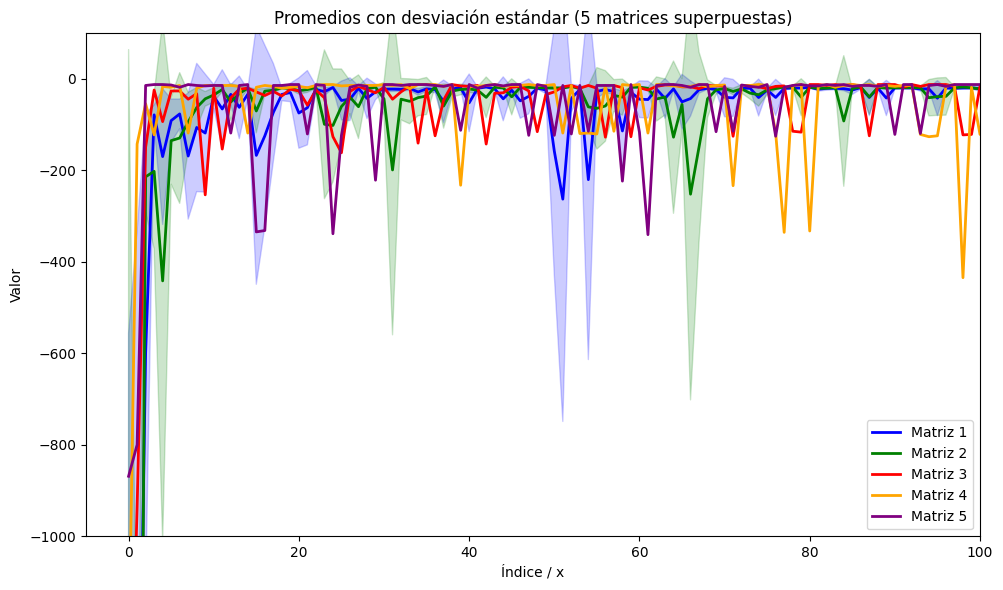

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# === Ejemplo de 5 matrices ===
# Cada matriz tiene filas = series, columnas = puntos en x

matriz1 = np.array(me_matrix_td5)
matriz2 = np.array(me_matrix_td1)
matriz3 = np.array(me_matrix_dyna_05)
matriz4 = np.array(me_matrix_dyna_20)
matriz5 = np.array(me_matrix_dyna_50)

# Guardamos todas las matrices en una lista para iterar fácilmente
matrices = [matriz1, matriz2, matriz3, matriz4, matriz5]
colores = ['blue', 'green', 'red', 'orange', 'purple']  # colores para distinguirlas

# Eje x (basado en número de columnas)
x = np.arange(matriz1.shape[1])

# === Graficar ===
plt.figure(figsize=(10,6))

for i, matriz in enumerate(matrices):
    mean = np.mean(matriz, axis=0)   # promedio por columna
    std = np.std(matriz, axis=0)     # desviación estándar por columna

    # Curva principal
    plt.plot(x, mean, color=colores[i], label=f'Matriz {i+1}', linewidth=2)

    # Banda ±1σ
    plt.fill_between(x, mean-std, mean+std, color=colores[i], alpha=0.2)

plt.xlabel("Índice / x")
plt.ylabel("Valor")
plt.title("Promedios con desviación estándar (5 matrices superpuestas)")
plt.legend()
plt.tight_layout()
plt.ylim(-1000,100)
plt.xlim(-5,100)
plt.show()


## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).
